In [2]:
import os, argparse, json, re
from collections import defaultdict
import customutils
import pandas as pd
import numpy as np

LABELS = customutils.get_classes('configs/halpe26_classes.txt')
LABELS_COCOWB = customutils.get_classes('configs/cocowb_classes.txt')
LABELS_COCO = customutils.get_classes('configs/coco_classes.txt')
LABELS_FOOT = ['LBigToe','RBigToe','LSmallToe','RSmallToe','LHeel','RHeel']
LABELS_MISSING = ['Head','Neck','Hip']

df_running_annotations = customutils.load_images_dataframe()

In [22]:
lst_filenames = [
    'World_Athletics_Women_10000m_Oregon_2022_10.mp4' 
]

In [23]:
df_test = df_running_annotations[(df_running_annotations['file_name'].isin(lst_filenames))]['image_id']
df_test

9220    33000
9221    33001
9222    33002
9223    33003
9224    33004
        ...  
9385    33080
9386    33081
9387    33082
9388    33083
9389    33084
Name: image_id, Length: 170, dtype: int64

Initialize dataframe

In [5]:
df = customutils.load_keypoints_dataframe()
df[df.duplicated(subset=['id'],keep=False)]
df = df.drop(columns=['iscrowd', 'num_keypoints'])
df = df.set_index(['id'])

df_categories = customutils.load_categories_dataframe()
kpts_classes = df_categories[df_categories['id'] == 1]['keypoints'][0]

df['kpts_alphapose'] = ""
df['kpts_vitpose'] = ""
df['kpts_cotracker'] = ""
df['kpts_cotracker2'] = ""
df['kpts_cotracker3'] = ""
df['dist_vitpose'] = np.ones((len(df),1)) * np.inf
df['dist_alphapose'] = np.ones((len(df),1)) * np.inf
df['dist_cotracker'] = np.ones((len(df),1)) * np.inf
df['dist_cotracker2'] = np.ones((len(df),1)) * np.inf
df['dist_cotracker3'] = np.ones((len(df),1)) * np.inf
df['oks_alphapose'] = float(0.0)
df['oks_cotracker'] = float(0.0)
df['oks_cotracker2'] = float(0.0)
df['oks_cotracker3'] = float(0.0)
df['oks_coco_alphapose'] = float(0.0)
df['oks_coco_vitpose'] = float(0.0)
df['oks_coco_cotracker'] = float(0.0)
df['oks_coco_cotracker2'] = float(0.0)
df['oks_coco_cotracker3'] = float(0.0)
df['oks_foot_alphapose'] = float(0.0)
df['oks_foot_vitpose'] = float(0.0)
df['oks_foot_cotracker'] = float(0.0)
df['oks_foot_cotracker2'] = float(0.0)
df['oks_foot_cotracker3'] = float(0.0)
df['alphapose_idx'] = ""
df['cotracker_idx'] = ""
df['head_size'] = ""
df['pckh_alphapose'] = ""
df['pckh_vitpose'] = ""
df['pckh_cotracker'] = ""
df['pckh_cotracker2'] = ""
df['pckh_cotracker3'] = ""
df

,image_id,idx,category_id,bbox,bbox_head,area,keypoints,kpts_alphapose,kpts_vitpose,kpts_cotracker,...,oks_foot_cotracker2,oks_foot_cotracker3,alphapose_idx,cotracker_idx,head_size,pckh_alphapose,pckh_vitpose,pckh_cotracker,pckh_cotracker2,pckh_cotracker3
id,,,,,,,,,,,,,,,,,,,,,
1000,1000,0,1,"[957.5031, 204.6478, 294.4987, 641.9175]","[1124.2617, 190.1271, 87.8589, 110.745]",189043.869257,"[1132.7201, 271.7583, 2, 1151.8834, 256.5806, ...",,,,...,0.0,0.0,,,,,,,,
1001,1001,0,1,"[895.2875, 201.4572, 396.59609999999986, 639.6...","[1124.0, 180.0, 91.0, 125.0]",253699.828317,"[1135.4403, 262.4473, 2, 1151.8834, 253.39, 2,...",,,,...,0.0,0.0,,,,,,,,
1002,1002,0,1,"[876.5417, 207.8383, 455.8919000000001, 641.2885]","[1124.0, 171.0, 89.0, 121.0]",292358.232713,"[1132.7201, 255.8056, 2, 1148.6928, 247.0089, ...",,,,...,0.0,0.0,,,,,,,,
1003,1003,0,1,"[892.6316, 187.0998, 445.91919999999993, 658.8...","[1117.0, 169.0, 96.0, 118.0]",293787.800419,"[1129.5295, 249.4245, 2, 1145.5023, 240.6278, ...",,,,...,0.0,0.0,,,,,,,,
1004,1004,0,1,"[912.8355, 201.4572, 406.572, 681.1703]","[1117.0, 169.0, 93.0, 116.0]",276944.771212,"[1132.7201, 249.4245, 2, 1148.6928, 240.6278, ...",,,,...,0.0,0.0,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145160,45160,1,1,"[749.0932, 271.5931, 241.01109999999994, 816.5...","[784.0, 225.0, 96.0, 141.0]",196795.299998,"[811.8716, 319.3694, 2, 827.6156, 303.8024, 2,...",,,,...,0.0,0.0,,,,,,,,
145161,45161,1,1,"[749.0932, 271.5931, 241.01109999999994, 816.5...","[784.0, 225.0, 96.0, 141.0]",196795.299998,"[811.8716, 319.3694, 2, 827.6156, 303.8024, 2,...",,,,...,0.0,0.0,,,,,,,,
145162,45162,1,1,"[749.0932, 271.5931, 241.01109999999994, 816.5...","[784.0, 225.0, 96.0, 141.0]",196795.299998,"[811.8716, 319.3694, 2, 827.6156, 303.8024, 2,...",,,,...,0.0,0.0,,,,,,,,


In [6]:
def eval_PCKh(id, keypoint_visible_array, gt_keypoints_array, eval_keypoints_array, eval_keypoint_visible_array, headsize, threshold=0.5):
    
    eval_keypoint_visible_array = np.array(eval_keypoint_visible_array)
    eval_keypoint_visible_array = eval_keypoint_visible_array - np.ones(len(eval_keypoint_visible_array))
    #eval_keypoint_visible_array = np.multiply(eval_keypoints_array, eval_keypoint_visible_array)
    eval_keypoints_array = eval_keypoints_array * eval_keypoint_visible_array[:, np.newaxis]

    # keypoints error
    keypoints_error = eval_keypoints_array - gt_keypoints_array
    keypoints_error = np.linalg.norm(keypoints_error, axis=1)

    # normalized head size
    # headsizes = headboxes_array[1, :, :] - headboxes_array[0, :, :]
    # headsizes = np.linalg.norm(headsizes, axis=0)
    # headsizes *= HEAD_SCALE_BIAS
    
    keypoint_visible_array = np.array(keypoint_visible_array)
    keypoint_visible_array = keypoint_visible_array - np.ones(len(keypoint_visible_array))


    # scaled keypoints error with head size
    scale = np.multiply(headsize, np.ones(len(keypoints_error)))
    scaled_keypoints_error = np.divide(keypoints_error, scale)
    scaled_keypoints_error = np.multiply(scaled_keypoints_error, keypoint_visible_array)

    # calculate PCKh@threshold score
    keypoint_count = len(keypoint_visible_array)
    PCKh = np.multiply((scaled_keypoints_error < threshold), keypoint_visible_array)
    # PCKh = np.divide(100. * np.sum(less_than_threshold, axis=1), keypoint_count)
    # PCKh = np.divide(100. * less_than_threshold, keypoint_count)

    # PCKh = np.ma.array(PCKh, mask=False)
    #PCKh.mask[6:8] = True
    return PCKh
    

In [7]:
def edit_keypoints(kpts):
    kpts = np.array(kpts).reshape(-1,3).astype(float)
    vi = kpts[:,2]
    kpts = kpts[:,0:2]
    return kpts, vi

def get_keypoint(kpts, id):
    index = kpts_classes.index(id)
    return [kpts[index*3],kpts[(index*3)+1],kpts[(index*3)+2]]

def load_keypoints(root, model):
    dist = 'dist_' + str.lower(model)
    dist_joints = 'dist_joints_' + str.lower(model)
    kpts = 'kpts_' + str.lower(model)
    pck = 'pck_' + str.lower(model)
    oks = 'oks_' + str.lower(model)
    oks_coco = 'oks_coco_' + str.lower(model)
    oks_foot = 'oks_foot_' + str.lower(model)
    file = os.path.join(root, model, 'person_keypoints_running.json')
    with open(file, 'r') as f:
        predictions = json.load(f)
        d = {}
        
        empty_keypoint = [0, 0, 0]        

        for prediction in predictions:

            # if prediction['image_id'] not in df_running_annotations['image_id'][(df_running_annotations['file_name'].isin(lst_filenames))].values:
                # continue
            idx = -1
            mask_frame = df['image_id'] == prediction['image_id']
            gts = df[mask_frame]
            dt = prediction['keypoints']
            # check if we have missing joints (compared to GT)
            if len(dt) < len(LABELS)*3:
                i = 0
                for label in LABELS:
                    if label not in LABELS_COCOWB:
                        dt[i:i] = empty_keypoint
                    i += 3

            kpts1, vi1 = edit_keypoints(dt)
            min_dist = np.inf
            
            # for i in range(len(gts)):
            for pose_id in gts.index:

                gt = gts['keypoints'][pose_id]
                bbox_head = gts['bbox_head'][pose_id]
                kpts2, vi2 = edit_keypoints(gt)
                d = np.linalg.norm(kpts1 - kpts2, ord=2, axis=1)
                v = np.ones(len(d))

                for part in range(len(d)):
                    if vi1[part] == 0 or vi2[part] == 0:
                        d[part] = 0
                        v[part] = 0
                                        
                area = customutils.compute_area_keypoints(gt)

                # compute head size for distance normalization
                head = get_keypoint(gt,"head")
                neck = get_keypoint(gt,"neck")

                headSize = 1
                if bbox_head[2] > 0:
                    headSize = 0.6 * np.sqrt(bbox_head[2]**2 + bbox_head[3]**2) 
                elif (len(head) > 0 and len(neck) > 0):
                    headSize = customutils.get_head_size(head[0], head[1], neck[0], neck[1])
                # normalize distance
                dNorm = np.sum(d)/headSize

                oks_val = customutils.OKS(gt, dt, area, 0, 26)
                oks_val_coco = customutils.OKS(gt, dt, area, 0, 17)
                oks_val_foot = customutils.OKS(gt, dt, area, 20, 26)
                pckh = eval_PCKh(pose_id, vi2, kpts2, kpts1, vi1, headSize)

                if dNorm < min_dist and dNorm <= gts[dist][pose_id]:

                    min_dist = dNorm
                    min_dist_joints = d/headSize
                    df.loc[pose_id, dist] = min_dist
                    df.loc[pose_id, dist_joints] = ','.join(str(element) for element in min_dist_joints)
                    df.loc[pose_id, 'head_size'] = headSize
                    df.loc[pose_id, pck] = ','.join(str(element) for element in pckh)
                    df.loc[pose_id, kpts] = ','.join(str(element) for element in dt)
                    df.loc[pose_id, oks] = oks_val
                    df.loc[pose_id, oks_coco] = oks_val_coco
                    df.loc[pose_id, oks_foot] = oks_val_foot
                    if 'idx' in prediction:
                        if model == 'alphapose':
                            df.loc[pose_id, 'alphapose_idx'] = prediction['idx']
                        else:
                            for pose_id2 in gts.index:
                                if pose_id != pose_id2 and df.loc[pose_id2, 'cotracker_idx'] == prediction['idx'] and df.loc[pose_id, dist] < df.loc[pose_id2, dist]:
                                    df.loc[pose_id2, 'cotracker_idx'] = -1
                            df.loc[pose_id, 'cotracker_idx'] = prediction['idx']


In [8]:
root = '../videos/results/'
load_keypoints(root, 'ViTPose')
#load_keypoints(root, 'alphapose')

In [126]:

df['kpts_openpose'] = ""
df['dist_openpose'] = np.ones((len(df),1)) * np.inf
df['oks_openpose'] = float(0.0)
df['oks_coco_openpose'] = float(0.0)
df['oks_foot_openpose'] = float(0.0)
df['pckh_openpose'] = ""
df['kpts_hrnet'] = ""
df['dist_hrnet'] = np.ones((len(df),1)) * np.inf
df['oks_hrnet'] = float(0.0)
df['oks_coco_hrnet'] = float(0.0)
df['oks_foot_hrnet'] = float(0.0)
df['pckh_hrnet'] = ""

load_keypoints(root, 'openpose')
load_keypoints(root, 'HRNet')

In [9]:
root = '../data/videos/results/'
load_keypoints(root, 'cotracker3')

In [19]:
root = '../data/videos/results/'
load_keypoints(root, 'cotracker2')

In [17]:
root = '../data/videos/results/'
load_keypoints(root, 'cotracker')

In [10]:
def computeAP(oks, df, thresh):
    T = len(df[df['idx'] != '-1'])
    idxs = np.argwhere((df[oks] >= thresh) & (df['idx'] != '-1'))
    ap = 100.0*len(idxs)/T
    return ap

def computeAllAP(oks, df):
    distThresh = 0.5
    ap50 = computeAP(oks, df, distThresh)
    ap = np.copy(ap50)
    for i in range(9):
        distThresh += 0.05
        ap += computeAP(oks, df, distThresh)
    ap75 = computeAP(oks, df, 0.75)
    ap = ap/10
    print('AP (' + oks + '): ' + str(ap))
    #print('AP0.5 (' + oks + '): ' + str(ap50))
    #print('AP0.75 (' + oks + '): ' + str(ap75))

def computePCKh(model, df):
    pckh = df['pck_' + model].values
    pckh_sum = np.zeros(26)
    cnt = 0
    for p in pckh:    
        if p != 'nan':
            cnt += 1
            pckh_sum += np.array(p.split(',')).astype(float)
    
    PCKh = 100*(pckh_sum/cnt)
    
    # get index of keypoints
    head_top = kpts_classes.index('head')
    left_shoulder = kpts_classes.index('left_shoulder')
    left_elbow = kpts_classes.index('left_elbow')
    left_wrist = kpts_classes.index('left_wrist')
    left_hip = kpts_classes.index('left_hip')
    left_knee = kpts_classes.index('left_knee')
    left_ankle = kpts_classes.index('left_ankle')
    left_heel = kpts_classes.index('left_heel')
    left_big_toe = kpts_classes.index('left_big_toe')
    left_small_toe = kpts_classes.index('left_small_toe')

    right_shoulder = kpts_classes.index('right_shoulder')
    right_elbow = kpts_classes.index('right_elbow')
    right_wrist = kpts_classes.index('right_wrist')
    right_hip = kpts_classes.index('right_hip')
    right_knee = kpts_classes.index('right_knee')
    right_ankle = kpts_classes.index('right_ankle')
    right_heel = kpts_classes.index('right_heel')
    right_big_toe = kpts_classes.index('right_big_toe')
    right_small_toe = kpts_classes.index('right_small_toe')

    # form PCKh metric dict
    pckh_dict = {}
    pckh_dict['Head'] = round(PCKh[head_top], 2)
    pckh_dict['Shoulder'] = round(0.5 * (PCKh[left_shoulder] + PCKh[right_shoulder]), 2)
    pckh_dict['Elbow'] = round(0.5 * (PCKh[left_elbow] + PCKh[right_elbow]), 2)
    pckh_dict['Wrist'] = round(0.5 * (PCKh[left_wrist] + PCKh[right_wrist]), 2)
    pckh_dict['Hip'] = round(0.5 * (PCKh[left_hip] + PCKh[right_hip]), 2)
    pckh_dict['Knee'] = round(0.5 * (PCKh[left_knee] + PCKh[right_knee]), 2)
    pckh_dict['Ankle'] = round(0.5 * (PCKh[left_ankle] + PCKh[right_ankle]), 2)
    pckh_dict['Heel'] = round(0.5 * (PCKh[left_heel] + PCKh[right_heel]), 2)
    pckh_dict['Toes'] = round(0.25 * (PCKh[left_big_toe] + PCKh[left_small_toe] + PCKh[right_small_toe] + PCKh[right_big_toe]), 2)
    mean = np.mean(PCKh)

    PCKh = np.ma.array(PCKh, mask=False)
    PCKh.mask[20:26] = True

    if model == 'vitpose' or model == 'cotracker3':
        PCKh.mask[17:20] = True

    avg_body = np.mean(PCKh)

    # show PCKh metric
    print(model + " PCKh evaluation: Shoulder, Elbow, Wrist, Hip, Knee, Ankle, Heel, Toes, AVG(whole-body), AVG(body) ")
    print('{:.2f} {:.2f}  {:.2f}  {:.2f} {:.2f}  {:.2f}  {:.2f} {:.2f} {:.2f} {:.2f}'.format(pckh_dict['Shoulder'],
                                                                            pckh_dict['Elbow'],
                                                                            pckh_dict['Wrist'],
                                                                            pckh_dict['Hip'],
                                                                            pckh_dict['Knee'],
                                                                            pckh_dict['Ankle'],
                                                                            pckh_dict['Heel'],
                                                                            pckh_dict['Toes'],
                                                                            mean, avg_body))


In [131]:
computePCKh('vitpose', df)

vitpose PCKh evaluation: Shoulder, Elbow, Wrist, Hip, Knee, Ankle, Heel, Toes, AVG(whole-body), AVG(body) 
88.98 79.03  84.59  90.87 89.09  81.32  75.95 76.15 72.47 83.98


In [132]:
computePCKh('alphapose', df)
computePCKh('vitpose', df)
computePCKh('cotracker2', df)
computePCKh('cotracker', df)
computePCKh('cotracker3', df)
computePCKh('openpose', df)
computePCKh('hrnet', df)

alphapose PCKh evaluation: Shoulder, Elbow, Wrist, Hip, Knee, Ankle, Heel, Toes, AVG(whole-body), AVG(body) 
88.24 75.26  77.00  89.32 84.95  72.43  66.36 66.71 79.07 82.81
vitpose PCKh evaluation: Shoulder, Elbow, Wrist, Hip, Knee, Ankle, Heel, Toes, AVG(whole-body), AVG(body) 
88.98 79.03  84.59  90.87 89.09  81.32  75.95 76.15 72.47 83.98
cotracker2 PCKh evaluation: Shoulder, Elbow, Wrist, Hip, Knee, Ankle, Heel, Toes, AVG(whole-body), AVG(body) 
66.91 32.09  19.68  64.89 17.60  9.77  9.09 11.19 31.06 37.23
cotracker PCKh evaluation: Shoulder, Elbow, Wrist, Hip, Knee, Ankle, Heel, Toes, AVG(whole-body), AVG(body) 
72.53 52.10  41.97  71.61 46.47  33.42  32.74 36.91 54.45 60.12
cotracker3 PCKh evaluation: Shoulder, Elbow, Wrist, Hip, Knee, Ankle, Heel, Toes, AVG(whole-body), AVG(body) 
74.85 55.42  47.53  74.02 52.97  39.07  39.40 43.78 49.06 60.09
openpose PCKh evaluation: Shoulder, Elbow, Wrist, Hip, Knee, Ankle, Heel, Toes, AVG(whole-body), AVG(body) 
82.99 70.39  70.44  83.76 77.

In [46]:

computeAllAP('oks_alphapose', df)
computeAllAP('oks_coco_alphapose', df)
computeAllAP('oks_foot_alphapose', df)

AP (oks_alphapose): 54.534269199009074
AP (oks_coco_alphapose): 60.37241948802642
AP (oks_foot_alphapose): 48.058629232039635


In [128]:
computeAllAP('oks_vitpose', df)
computeAllAP('oks_coco_vitpose', df)
computeAllAP('oks_foot_vitpose', df)
computeAllAP('oks_openpose', df)
computeAllAP('oks_coco_openpose', df)
computeAllAP('oks_foot_openpose', df)
computeAllAP('oks_hrnet', df)
computeAllAP('oks_coco_hrnet', df)
computeAllAP('oks_foot_hrnet', df)

AP (oks_vitpose): 67.98100743187447
AP (oks_coco_vitpose): 70.19900908340216
AP (oks_foot_vitpose): 64.54004954582989
AP (oks_openpose): 50.90916597853014
AP (oks_coco_openpose): 60.721717588769614
AP (oks_foot_openpose): 43.50949628406276
AP (oks_hrnet): 58.568125516102384
AP (oks_coco_hrnet): 66.79025598678777
AP (oks_foot_hrnet): 42.82246077621801


In [50]:

computeAllAP('oks_cotracker', df)
computeAllAP('oks_coco_cotracker', df)
computeAllAP('oks_foot_cotracker', df)
computeAllAP('oks_cotracker2', df)
computeAllAP('oks_coco_cotracker2', df)
computeAllAP('oks_foot_cotracker2', df)
computeAllAP('oks_cotracker3', df)
computeAllAP('oks_coco_cotracker3', df)
computeAllAP('oks_foot_cotracker3', df)

AP (oks_cotracker): 28.880264244426094
AP (oks_coco_cotracker): 32.97935590421139
AP (oks_foot_cotracker): 23.2840627580512
AP (oks_cotracker2): 5.7299752270850535
AP (oks_coco_cotracker2): 11.941370767960365
AP (oks_foot_cotracker2): 3.483071841453345
AP (oks_cotracker3): 35.54830718414534
AP (oks_coco_cotracker3): 38.80016515276632
AP (oks_foot_cotracker3): 32.17423616845583


In [9]:

def computeAllAP_file(file, idx, oks, df, all = 0):
    distThresh = 0.5
    ap50 = computeAP(oks, df, distThresh)
    ap = np.copy(ap50)
    for i in range(9):
        distThresh += 0.05
        ap += computeAP(oks, df, distThresh)
    ap = ap/10
    field = oks.replace('oks_','').replace('_',',')
    if all == 1:
        field = 'all,' + field
    print(field + ',' + file + ',' + str(idx) + ',' + str(ap))
    

def compute_mot(model):
    lst_filenames = df_running_annotations['file_name'].unique()
    mota_dict = defaultdict(list)
    mota_arr = np.zeros(27)

    # fn_default = np.ones((len(kpts1),1))
    for filename in lst_filenames:
        # if filename.startswith('clip_tri_1'):
            idsw_dict = defaultdict(list)
            fns = defaultdict(list)
            fps = defaultdict(list)
            gts = np.zeros(26)
            # gts = 0
            df_lat = df_running_annotations[df_running_annotations['file_name'] == filename]['image_id']
            df_video = df[(df['image_id'].isin(df_lat))]
            lst_idx = df_video['idx'].unique()
            for idx in lst_idx:
                df_subset = df_video[df_video['idx'] == idx]
                
                for frame_id in df_subset.index:
                    image_id = df_subset['image_id'][frame_id]
                    frame_number = image_id % 1000
                    #df_subset[df_subset['pck_alphapose'][frame_id] > 0] = 1
                    if df_subset['pck_' + model][frame_id] is not None:
                        # calculate FN and FP per joint
                        kpts2, vi2 = edit_keypoints(df_subset['keypoints'][frame_id])
                        vi2 = vi2 - np.ones(len(vi2))
                        
                        pckh = df_subset['pck_' + model][frame_id]
                        pckh = np.array(pckh.split(',')).astype(float)
                        fn_mask = (pckh == 0) & (vi2 == 1)
                        fp_mask = (pckh == 1) & (vi2 == 0)

                        # fp = np.sum(fp_mask)
                        # fn = np.sum(fn_mask)
                        # gts += np.sum(vi2)
                        gts += vi2
                        
                        if image_id in gts:
                            fns[image_id] = fns[image_id] + fn_mask.astype(float)
                            fps[image_id] = fps[image_id] + fp_mask.astype(float)
                        else:
                            fns[image_id] = fn_mask.astype(float)
                            fps[image_id] = fp_mask.astype(float)
                        
                    if frame_number != 0:
                        prev_frame = df_subset[df_subset['image_id'] == image_id-1]
                        if prev_frame.iloc[0]['alphapose_idx'] != df_subset['alphapose_idx'][frame_id]:
                            # IDSW
                            if image_id in idsw_dict :
                                idsw_dict[image_id] = idsw_dict[image_id] + np.ones(len(vi2))
                            else:
                                idsw_dict[image_id] = np.zeros(len(vi2))
                            continue
    
            mota_top = np.zeros(26)
            for val, image_id in enumerate(fns):
                mota_top += fns[image_id] + fps[image_id]
                if image_id in idsw_dict:
                    mota_top += idsw_dict[image_id]

            mota = 100*(1-np.divide(mota_top, gts))
            mota = np.where(np.isfinite(mota), mota, np.nan)
            mota_all = np.append(mota, np.nanmean(mota))
            mota_dict[filename] = mota_all
            mota_arr += mota_all
    

    # print(model + ' MOTA: ' + str (mota_dict))
    mota_arr = mota_arr/len(lst_filenames)
    # get index of keypoints
    head_top = kpts_classes.index('head')
    left_shoulder = kpts_classes.index('left_shoulder')
    left_elbow = kpts_classes.index('left_elbow')
    left_wrist = kpts_classes.index('left_wrist')
    left_hip = kpts_classes.index('left_hip')
    left_knee = kpts_classes.index('left_knee')
    left_ankle = kpts_classes.index('left_ankle')
    left_heel = kpts_classes.index('left_heel')
    left_big_toe = kpts_classes.index('left_big_toe')
    left_small_toe = kpts_classes.index('left_small_toe')

    right_shoulder = kpts_classes.index('right_shoulder')
    right_elbow = kpts_classes.index('right_elbow')
    right_wrist = kpts_classes.index('right_wrist')
    right_hip = kpts_classes.index('right_hip')
    right_knee = kpts_classes.index('right_knee')
    right_ankle = kpts_classes.index('right_ankle')
    right_heel = kpts_classes.index('right_heel')
    right_big_toe = kpts_classes.index('right_big_toe')
    right_small_toe = kpts_classes.index('right_small_toe')

    # form PCKh metric dict
    pckh_dict = {}
    pckh_dict['Head'] = round(mota_arr[head_top], 2)
    pckh_dict['Shoulder'] = round(0.5 * (mota_arr[left_shoulder] + mota_arr[right_shoulder]), 2)
    pckh_dict['Elbow'] = round(0.5 * (mota_arr[left_elbow] + mota_arr[right_elbow]), 2)
    pckh_dict['Wrist'] = round(0.5 * (mota_arr[left_wrist] + mota_arr[right_wrist]), 2)
    pckh_dict['Hip'] = round(0.5 * (mota_arr[left_hip] + mota_arr[right_hip]), 2)
    pckh_dict['Knee'] = round(0.5 * (mota_arr[left_knee] + mota_arr[right_knee]), 2)
    pckh_dict['Ankle'] = round(0.5 * (mota_arr[left_ankle] + mota_arr[right_ankle]), 2)
    pckh_dict['Heel'] = round(0.5 * (mota_arr[left_heel] + mota_arr[right_heel]), 2)
    pckh_dict['Toes'] = round(0.25 * (mota_arr[left_big_toe] + mota_arr[left_small_toe] + mota_arr[right_small_toe] + mota_arr[right_big_toe]), 2)
    mean = np.mean(mota_arr[-1])

    # show PCKh metric
    print(model + " MOTA: Shoulder, Elbow, Wrist, Hip, Knee, Ankle, Heel, Toes, Mean")
    print('{:.2f}  {:.2f}  {:.2f} {:.2f}  {:.2f}  {:.2f} {:.2f} {:.2f} {:.2f}'.format(pckh_dict['Shoulder'],
                                                                            pckh_dict['Elbow'],
                                                                            pckh_dict['Wrist'],
                                                                            pckh_dict['Hip'],
                                                                            pckh_dict['Knee'],
                                                                            pckh_dict['Ankle'],
                                                                            pckh_dict['Heel'],
                                                                            pckh_dict['Toes'],
                                                                            mean))
    

    

In [ ]:

compute_mot('alphapose')
compute_mot('cotracker2')
compute_mot('cotracker')
compute_mot('cotracker3')

In [76]:
   

def compute_mot(model):
    lst_filenames = df_running_annotations['file_name'].unique()
    idsw_dict = defaultdict(list)
    fns = defaultdict(list)
    fps = defaultdict(list)
    gts = np.zeros(26)

    # fn_default = np.ones((len(kpts1),1))
    for filename in lst_filenames:
        # if filename.startswith('clip_tri_1'):
            # gts = 0
            df_lat = df_running_annotations[df_running_annotations['file_name'] == filename]['image_id']
            df_video = df[(df['image_id'].isin(df_lat))]
            lst_idx = df_video['idx'].unique()
            for idx in lst_idx:
                df_subset = df_video[df_video['idx'] == idx]
                
                for frame_id in df_subset.index:
                    image_id = df_subset['image_id'][frame_id]
                    frame_number = image_id % 1000
                    #df_subset[df_subset['pck_alphapose'][frame_id] > 0] = 1
                    if df_subset['pck_' + model][frame_id] is not None:
                        # calculate FN and FP per joint
                        kpts2, vi2 = edit_keypoints(df_subset['keypoints'][frame_id])
                        vi2 = vi2 - np.ones(len(vi2))
                        
                        pckh = df_subset['pck_' + model][frame_id]
                        pckh = np.array(pckh.split(',')).astype(float)
                        fn_mask = (pckh == 0) & (vi2 == 1)
                        fp_mask = (pckh == 1) & (vi2 == 0)

                        # fp = np.sum(fp_mask)
                        # fn = np.sum(fn_mask)
                        # gts += np.sum(vi2)
                        gts += vi2
                        
                        if image_id in gts:
                            fns[image_id] = fns[image_id] + fn_mask.astype(float)
                            fps[image_id] = fps[image_id] + fp_mask.astype(float)
                        else:
                            fns[image_id] = fn_mask.astype(float)
                            fps[image_id] = fp_mask.astype(float)
                        
                    if frame_number != 0:
                        prev_frame = df_subset[df_subset['image_id'] == image_id-1]
                        if prev_frame.iloc[0]['alphapose_idx'] != df_subset['alphapose_idx'][frame_id]:
                            # IDSW
                            if image_id in idsw_dict :
                                idsw_dict[image_id] = idsw_dict[image_id] + np.ones(len(vi2))
                            else:
                                idsw_dict[image_id] = np.zeros(len(vi2))
                            continue
    
    mota_top = np.zeros(26)
    for val, image_id in enumerate(fns):
        mota_top += fns[image_id] + fps[image_id]
        if image_id in idsw_dict:
            mota_top += idsw_dict[image_id]

    mota = 1-np.divide(mota_top, gts)
    print(model + ' MOTA: ' + str (mota) + ' AVG ' + str(np.mean(mota)))

compute_mot('alphapose')
compute_mot('cotracker')
compute_mot('cotracker2')
compute_mot('cotracker3')
    

alphapose MOTA: [0.97590257 0.97608427 0.97574431 0.96715536 0.96578538 0.97133236
 0.96928508 0.94029406 0.95256648 0.92006864 0.92228119 0.95727862
 0.96073981 0.94576561 0.93798518 0.89619439 0.90003678 0.97694786
 0.97678837 0.96802857 0.8733652  0.87078189 0.8739048  0.8716142
 0.8780443  0.88208787] AVG 0.9348485833131698
cotracker MOTA: [0.9399739  0.96099459 0.93362522 0.93885669 0.9217211  0.94639607
 0.92780229 0.88416451 0.86451739 0.81078396 0.81595754 0.92761346
 0.9223203  0.83182207 0.82533522 0.77666607 0.78793452 0.94315459
 0.95398976 0.92873944 0.79092631 0.80338363 0.79830187 0.79666911
 0.77970775 0.79252722] AVG 0.8693801763115163
cotracker2 MOTA: [0.96241844 0.96925121 0.95472855 0.95738152 0.9368844  0.92701129
 0.92930274 0.82088218 0.78835103 0.72850434 0.73985788 0.91358025
 0.91517444 0.73515825 0.72785815 0.69108451 0.69965054 0.65124349
 0.6509995  0.63559544 0.71849914 0.7042524  0.71727938 0.70250732
 0.70011947 0.6970522 ] AVG 0.7913318479890156
cotrack

In [10]:
def computeAPs(model):
    lst_filenames = df_running_annotations['file_name'].unique()

    for filename in lst_filenames:
        df_lat = df_running_annotations[df_running_annotations['file_name'] == filename]['image_id']
        df_video = df[(df['image_id'].isin(df_lat))]
        lst_idx = df_video['idx'].unique()
        for idx in lst_idx:
            df_subset = df_video[df_video['idx'] == idx]
            computeAllAP_file(filename, idx, 'oks_' + model, df_subset, 1)
            computeAllAP_file(filename, idx, 'oks_coco_' + model, df_subset)
            computeAllAP_file(filename, idx, 'oks_foot_' + model, df_subset)
    
#computeAPs('alphapose')
computeAPs('vitpose')
#computeAPs('cotracker')
#computeAPs('cotracker2')
#computeAPs('cotracker3')

all,vitpose,Athletics_Mixed_Tokyo_2020_20_1.mp4,0,63.93939393939395
coco,vitpose,Athletics_Mixed_Tokyo_2020_20_1.mp4,0,78.93939393939394
foot,vitpose,Athletics_Mixed_Tokyo_2020_20_1.mp4,0,45.90909090909091
all,vitpose,Athletics_Mixed_Tokyo_2020_20_1.mp4,1,83.18181818181819
coco,vitpose,Athletics_Mixed_Tokyo_2020_20_1.mp4,1,87.57575757575759
foot,vitpose,Athletics_Mixed_Tokyo_2020_20_1.mp4,1,71.66666666666667
all,vitpose,Athletics_Mixed_Tokyo_2020_39.mp4,0,72.625
coco,vitpose,Athletics_Mixed_Tokyo_2020_39.mp4,0,76.625
foot,vitpose,Athletics_Mixed_Tokyo_2020_39.mp4,0,63.5
all,vitpose,Athletics_Mixed_Tokyo_2020_39.mp4,1,68.625
coco,vitpose,Athletics_Mixed_Tokyo_2020_39.mp4,1,74.0
foot,vitpose,Athletics_Mixed_Tokyo_2020_39.mp4,1,59.125
all,vitpose,Athletics_Mixed_Tokyo_2020_5.mp4,0,76.39751552795032
coco,vitpose,Athletics_Mixed_Tokyo_2020_5.mp4,0,78.01242236024845
foot,vitpose,Athletics_Mixed_Tokyo_2020_5.mp4,0,71.73913043478261
all,vitpose,Athletics_Mixed_Tokyo_2020_5.mp4,1,62.23602484472

In [56]:
#pd.set_option('display.max_rows', None)

df_video = df[(df['image_id'].isin(df_test)) & (df['idx'] == 1)]
df_video

,image_id,idx,category_id,bbox,bbox_head,area,keypoints,kpts_alphapose,kpts_vitpose,kpts_cotracker,...,pckh_cotracker,pckh_cotracker2,pckh_cotracker3,dist_joints_vitpose,pck_vitpose,oks_vitpose,dist_joints_cotracker3,pck_cotracker3,dist_joints_cotracker,pck_cotracker
id,,,,,,,,,,,,,,,,,,,,,
133000,33000,1,1,"[515.0247, 210.6278, 381.025, 751.6436]","[749.8935, 203.195, 93.7881, 108.0173]",286395.002690,"[845.6841, 270.0573, 2, 830.3689, 254.0928, 1,...",,"841.806396484375,266.1380310058594,2,834.47705...","844.1063232421875,272.642333984375,2,837.01672...",...,,,,"0.06423492894298602,0.0728669753936063,0.04405...","1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0....",0.936429,"0.06423492894298602,0.0728669753936063,0.04405...","1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0....","0.035284250032149474,0.09268948898736086,0.082...","1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0...."
133001,33001,1,1,"[485.4184, 201.2342, 420.47029999999995, 727.7...","[746.0, 194.0, 98.3515, 110.1757]",306014.458060,"[836.2339, 265.2714, 2, 830.3992, 249.307, 1, ...",,"835.86181640625,260.97918701171875,2,835.86181...","840.4658203125,261.2569885253906,2,833.3956298...",...,,,,"0.048619552062428566,0.06921461699233843,0.008...","1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0....",0.960570,"0.048619552062428566,0.06921461699233843,0.008...","1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0....","0.0658265046021049,0.04188630078531211,0.03486...","1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0...."
133002,33002,1,1,"[444.6141, 193.39, 455.3568, 715.9949]","[743.0, 185.0, 101.0, 118.0]",326033.146480,"[837.2144, 261.3493, 2, 829.4187, 242.4433, 1,...",,"838.7575073242188,255.55133056640625,2,838.757...","840.045654296875,256.11676025390625,1,832.8269...",...,,,,"0.06438015850469662,0.10191539627843617,0.0320...","1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0....",0.956818,"0.07511075096667517,0.06311980416316582,0.0503...","0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0....","0.06383942244529674,0.03946733584070217,0.0524...","0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0...."
133003,33003,1,1,"[408.7243, 192.4094, 552.7533000000001, 733.9103]","[741.0, 183.0, 105.0, 122.0]",405671.340229,"[840.156, 258.4077, 2, 830.3992, 242.1093, 1, ...",,"839.4658203125,250.4212646484375,2,839.4658203...","843.4835205078125,255.8530731201172,2,836.3509...",...,,,,"0.08300267463707693,0.11598066859296163,0.0634...","1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1....",0.947229,"0.08300267463707693,0.11598066859296163,0.0634...","1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1....","0.043437156631576844,0.061862614459863546,0.08...","1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1...."
133004,33004,1,1,"[399.8562, 200.2537, 583.8052, 726.0845]","[737.0, 183.0, 111.0, 122.0]",423891.906739,"[844.8349, 260.1108, 2, 830.3992, 240.706, 1, ...",,"840.0906982421875,259.26806640625,2,840.090698...","845.0721435546875,260.5304870605469,1,839.0268...",...,,,,"0.048689298414666723,0.1062121611335997,0.0680...","1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0....",0.965022,"0.05212761261255965,0.13364444761569194,0.0335...","0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0....","0.004871500506777614,0.10814425566707914,0.011...","0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133080,33080,1,1,"[187.4042, 176.4084, 451.34599999999995, 899.7...","[484.0, 165.0, 135.3808, 141.8081]",406117.745705,"[611.4733, 266.8097, 2, 601.3385, 241.7483, 1,...",,"614.5189208984375,247.12823486328125,2,614.518...","620.7511596679688,250.19049072265625,2,613.440...",...,,,,"0.16930398883770906,0.15131305181835394,0.0909...","1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0....",0.869410,"0.1753329284678599,0.16657103710843132,0.09441...","1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0....","0.16180481927985793,0.16015697393366218,0.1075...","1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0...."
133081,33081,1,1,"[257.8115, 194.13

In [23]:
df_subset[(df_subset['oks_cotracker3'] < df_subset['oks_vitpose'])][['image_id','oks_vitpose', 'oks_cotracker3','oks_foot_vitpose','oks_foot_cotracker3']]

,image_id,oks_vitpose,oks_cotracker3,oks_foot_vitpose,oks_foot_cotracker3
id,,,,,
1002,1002,0.924794,0.868300,0.976162,0.797956
1003,1003,0.941594,0.862254,0.980320,0.814763
1004,1004,0.921789,0.842779,0.901227,0.756604
1006,1006,0.886801,0.721274,0.938069,0.472079
1007,1007,0.923863,0.574813,0.939754,0.353553
...,...,...,...,...,...
145156,45156,0.842943,0.814678,0.901157,0.909125
145159,45159,0.807955,0.803765,0.928922,0.909397
145160,45160,0.813465,0.809792,0.905955,0.909435


In [ ]:
pd.set_option('display.max_rows', None)

# get frames where solution is better than original
df_good = df[(df['oks_cotracker'] > df['oks_vitpose']) | (df['oks_foot_cotracker'] > df['oks_foot_alphapose'])][['image_id','oks_alphapose', 'oks_cotracker','oks_foot_alphapose','oks_foot_cotracker']]

Pelvis and lower limb kinematics experimnets

In [35]:
import math
import matplotlib.pyplot as plt
import numpy as np
 
def getSignedAngle(x, y, z):
    a = np.array([x[0],x[1]])
    b = np.array([y[0],y[1]])
    c = np.array([z[0],z[1]])

    ba = a - b
    bc = c - b

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.degrees(np.arccos(cosine_angle))

    # Compute the 2D cross product (scalar value)
    cross_product = ba[0] * bc[1] - ba[1] * bc[0]

    # Determine the sign of the angle based on the cross product value
    if cross_product < 0:
        angle = -angle

    return angle

def getAngle(x, y, z):
    a = np.array([x[0],x[1]])
    b = np.array([y[0],y[1]])
    c = np.array([z[0],z[1]])

    ba = a - b
    bc = c - b

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.degrees(np.arccos(cosine_angle))

    return angle

Knee Flexion/Extension

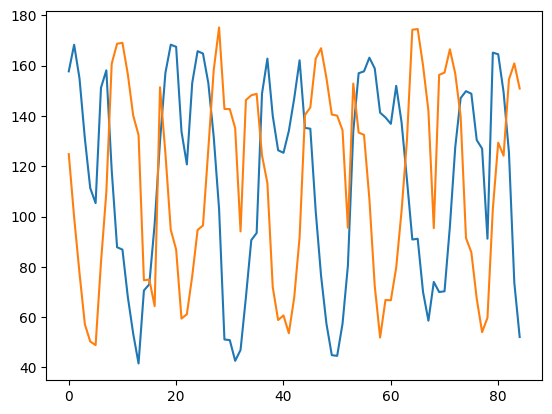

In [40]:
xpoints1 = []
ypoints1 = []
xpoints2 = []
ypoints2 = []

for pose_id in df_video.index:
    gt = np.array(df_video['kpts_cotracker'][pose_id].split(',')).astype(np.float32)
    frame = df_video['image_id'][pose_id] % 1000


    hip = get_keypoint(gt,"right_hip")
    knee = get_keypoint(gt,"right_knee")
    ankle = get_keypoint(gt,"right_heel")

    if hip[2] != 0 and knee[2] != 0 and ankle[2] != 0:
        angle = getAngle(hip, knee, ankle)

        xpoints1.append(frame)
        ypoints1.append(angle)
    
    hip = get_keypoint(gt,"left_hip")
    knee = get_keypoint(gt,"left_knee")
    ankle = get_keypoint(gt,"left_heel")

    if hip[2] != 0 and knee[2] != 0 and ankle[2] != 0:
        angle = getAngle(hip, knee, ankle)

        xpoints2.append(frame)
        ypoints2.append(angle)


xpoints1 = np.array(xpoints1)
ypoints1 = np.array(ypoints1)
xpoints2 = np.array(xpoints2)
ypoints2 = np.array(ypoints2)

# print(ypoints2)
# f = plt.figure()
# f.set_figwidth(10)
# f.set_figheight(3)

# plt.scatter(xpoints1, ypoints1, label= "right", color= "blue")
# plt.scatter(xpoints2, ypoints2, label= "left", color= "red")
# plt.plot(xpoints1, ypoints1, label = "line 1", linestyle='None')
# plt.plot(xpoints2, ypoints2, label = "line 2", linestyle='None')
# plt.show()

xpoints1 = np.array(xpoints1)
ypoints1 = np.array(ypoints1)
xpoints2 = np.array(xpoints2)
ypoints2 = np.array(ypoints2)

plt.plot(xpoints1, ypoints1, label = "line 1")
plt.plot(xpoints2, ypoints2, label = "line 2")
plt.show()

Hip Flexion/Extension

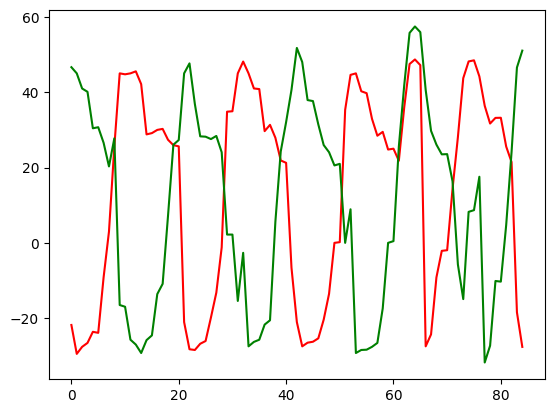

In [44]:

xpoints1 = []
ypoints1 = []
xpoints2 = []
ypoints2 = []

for pose_id in df_video.index:
    gt = np.array(df_video['kpts_cotracker'][pose_id].split(',')).astype(np.float32)
    frame = df_video['image_id'][pose_id] % 1000

    neck = get_keypoint(gt,"neck")
    hip = get_keypoint(gt,"right_hip")
    knee = get_keypoint(gt,"right_knee")
    hk = [hip[0], knee[1]]

    if hip[2] != 0 and knee[2] != 0 and neck[2] != 0:
        angle = getSignedAngle(knee, hip, hk)

        xpoints1.append(frame)
        ypoints1.append(angle)
    
    neck = get_keypoint(gt,"neck")
    hip = get_keypoint(gt,"left_hip")
    knee = get_keypoint(gt,"left_knee")
    hk = [hip[0], knee[1]]

    if hip[2] != 0 and knee[2] != 0 and neck[2] != 0:
        angle = getSignedAngle(knee, hip, hk)

        xpoints2.append(frame)
        ypoints2.append(angle)

xpoints1 = np.array(xpoints1)
ypoints1 = np.array(ypoints1)
xpoints2 = np.array(xpoints2)
ypoints2 = np.array(ypoints2)

plt.plot(xpoints1, ypoints1, label = "line 1", color= "red")
plt.plot(xpoints2, ypoints2, label = "line 2", color= "green")
plt.show()

Ankle Dorsi/Plantar

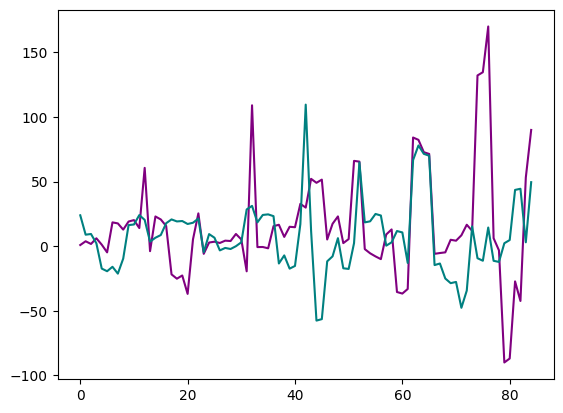

In [57]:

xpoints1 = []
ypoints1 = []
xpoints2 = []
ypoints2 = []

for pose_id in df_video.index:
    gt = np.array(df_video['kpts_cotracker'][pose_id].split(',')).astype(np.float32)
    frame = df_video['image_id'][pose_id] % 1000

    heel = get_keypoint(gt,"right_heel")
    ankle = get_keypoint(gt,"right_ankle")
    bigtoe = get_keypoint(gt,"right_big_toe")
    smalltoe = get_keypoint(gt,"right_small_toe")


    if heel[2] != 0 and ankle[2] != 0 and (bigtoe[2] != 0 or smalltoe[2] != 0):
        if bigtoe[2] == 0:
            toe = smalltoe
        elif smalltoe[2] == 0:
            toe = bigtoe
        else:
            toe = (np.array(smalltoe)+np.array(bigtoe))/2

        # heel = [ankle[0], toe[1]]
        angle = 90 - getSignedAngle(toe, ankle, heel)

        xpoints1.append(frame)
        ypoints1.append(angle)
    
    heel = get_keypoint(gt,"left_heel")
    ankle = get_keypoint(gt,"left_ankle")
    bigtoe = get_keypoint(gt,"left_big_toe")
    smalltoe = get_keypoint(gt,"left_small_toe")

    if heel[2] != 0 and ankle[2] != 0 and (bigtoe[2] != 0 or smalltoe[2] != 0):
        if bigtoe[2] == 0:
            toe = smalltoe
        elif smalltoe[2] == 0:
            toe = bigtoe
        else:
            toe = (np.array(smalltoe)+np.array(bigtoe))/2

        # heel = [ankle[0], toe[1]]
        angle = 90 - getSignedAngle(toe, ankle, heel)

        xpoints2.append(frame)
        ypoints2.append(angle)

xpoints1 = np.array(xpoints1)
ypoints1 = np.array(ypoints1)
xpoints2 = np.array(xpoints2)
ypoints2 = np.array(ypoints2)

plt.plot(xpoints1, ypoints1, label = "line 1", color= "purple")
plt.plot(xpoints2, ypoints2, label = "line 2", color= "teal")
plt.show()